In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

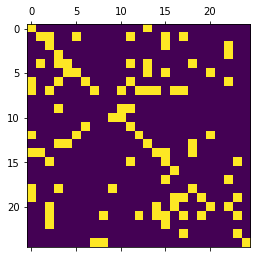

In [79]:
binary_graph = np.load('../binary_graph.npy')
coeffs = np.load('../neural_granger_causality_testing_anant/coeffs.npy')

lookback = 10
assets = 25

plt.matshow(binary_graph)

In [80]:
pairs = []
for i in range(len(binary_graph)):
    for j in range(i+1, len(binary_graph[i])):
        if binary_graph[i][j] == 1 and binary_graph[j][i] == 0 :
            pairs.append((i,j))
        elif binary_graph[i][j] == 0 and binary_graph[j][i] == 1:
            pairs.append((j,i))

print(pairs)
        
        

[(6, 0), (7, 0), (12, 0), (0, 13), (14, 0), (18, 0), (19, 0), (1, 2), (4, 1), (1, 5), (1, 11), (14, 1), (1, 15), (1, 17), (7, 2), (20, 2), (21, 2), (4, 3), (6, 3), (9, 3), (13, 3), (18, 3), (3, 22), (5, 4), (4, 11), (4, 18), (12, 5), (5, 13), (5, 15), (5, 20), (6, 22), (7, 10), (7, 12), (7, 13), (7, 14), (7, 16), (7, 17), (24, 7), (21, 8), (24, 8), (9, 11), (18, 9), (15, 11), (12, 20), (21, 12), (13, 18), (14, 15), (14, 18), (20, 14), (21, 14), (17, 15), (21, 15), (22, 15), (15, 23), (19, 16), (20, 16), (19, 17), (21, 17), (17, 22), (23, 17), (21, 19), (19, 23), (20, 22), (21, 23)]


In [81]:
print(coeffs.shape)



(1477, 25, 25, 25)


(array([ 13.,  44., 149., 297., 403., 317., 146.,  69.,  24.,  15.]),
 array([-0.00537162, -0.00412568, -0.00287974, -0.0016338 , -0.00038786,
         0.00085808,  0.00210402,  0.00334996,  0.0045959 ,  0.00584184,
         0.00708778], dtype=float32),
 <BarContainer object of 10 artists>)

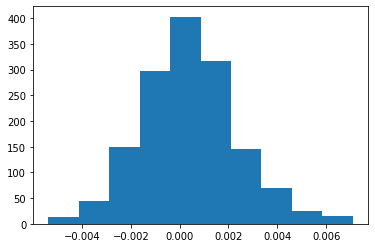

In [82]:
import random
t = random.randint(0, lookback-1)
r = random.randint(0, assets-1)
c = random.randint(0, assets-1)
values = coeffs[:, t, r, c]
plt.hist(values)

In [83]:
lower = np.zeros((lookback,assets,assets))
upper = np.zeros((lookback,assets,assets))

for i in range(lookback):
    for j in range(assets):
        for k in range(assets):
            values = coeffs[:, i, j, k]
            lower[i][j][k] = np.quantile(values, 0.25)
            upper[i][j][k] = np.quantile(values, 0.75)



In [84]:
normalized = pd.read_csv('../will_data/sameer_data/cv_norm_precovid_test5.csv')

signals = np.zeros((len(pairs),len(normalized)-lookback))

# create signals
for p in range(len(pairs)):
    pair = pairs[p]
    for day in range(lookback, len(normalized)-1):
        wUpVect = np.array(upper[:,pair[0],pair[1]])
        wLowVect = np.array(lower[:,pair[0],pair[1]])
        tVect = normalized.iloc[day-lookback : day, pair[0]+1].to_numpy()

        upperValue = 0
        lowerValue = 0
        for i in range(lookback):
            upperWeight = max(wUpVect[i],wLowVect[i]) if (tVect[i] > 0) else min(wUpVect[i],wLowVect[i])
            lowerWeight = max(wUpVect[i],wLowVect[i]) if (tVect[i] < 0) else min(wUpVect[i],wLowVect[i])
            upperValue = upperValue + tVect[i] * upperWeight
            lowerValue = lowerValue + tVect[i] * lowerWeight

        upperValue = upperValue - normalized.iloc[day-1, pair[1]+1]
        lowerValue = lowerValue - normalized.iloc[day-1, pair[1]+1]
        if upperValue < 0 :
            assert lowerValue < 0
            signals[p][day - lookback] = -1
        elif lowerValue > 0:
            assert upperValue > 0
            signals[p][day - lookback] = 1
        else:
            signals[p][day - lookback] = 0



    


In [91]:
# trading on the fucking signals
raw = pd.read_csv('../will_data/sameer_data/cv_raw_precovid_test5.csv')

def backtest(p):
    position = 0 # 0 if not holding stock, 1 if holding, -1 if shorting
    pct_change = []
    dates = []
    buy_price = 0.0
    sell_price = 0.0

    stock = pairs[p][1]+1;

    for day in range(lookback, len(normalized)-1):

        # exiting long position
        if signals[p][day-lookback] == 0 and position == 1:
            position = 0
            sell_price = raw.iloc[day, stock]

            pc = sell_price/buy_price
            pct_change.append(pc)
            dates.append(day)

        # exiting short position
        elif signals[p][day-lookback] == 0 and position -1:
            position = 0
            buy_price = raw.iloc[day,stock]

            pc = sell_price/buy_price
            pct_change.append(pc)
            dates.append(day)
        
        # long from neutral
        elif signals[p][day-lookback] == 1 and position == 0:
            position = 1
            buy_price = raw.iloc[day,stock]

        # short from neutral
        elif signals[p][day-lookback] == -1 and position == 0:
            position = -1
            sell_price = raw.iloc[day,stock]

        # long from short
        #elif signals[p][day-lookback] == 1 and position == -1:

    if position == 1:
        sell_price = raw.iloc[day, stock]
        pc = sell_price/buy_price
        pct_change.append(pc)
    
    if position == -1:
        buy_price = raw.iloc[day,stock]
        pc = sell_price/buy_price
        pct_change.append(pc)


    total_return = 1
    for i in range(len(pct_change)):
        total_return *= pct_change[i]
    total_return = (total_return)*100
    print('total return: ' + str(total_return))    
    

for p in range(len(pairs)):
    backtest(p)
    print('\n')

total return: 53.27564162333067


total return: 53.27564162333067


total return: 53.27564162333067


total return: 80.58537680744512


total return: 53.27564162333067


total return: 53.27564162333067


total return: 53.27564162333067


total return: 83.60611770330559


total return: 97.3799716273609


total return: 93.99528033386969


total return: 75.20874764139927


total return: 97.3799716273609


total return: 65.93605901479155


total return: 63.327352219299534


total return: 83.60611770330559


total return: 83.60611770330559


total return: 83.60611770330559


total return: 81.98829536262173


total return: 81.98829536262173


total return: 81.98829536262173


total return: 81.98829536262173


total return: 81.98829536262173


total return: 92.79894695676849


total return: 85.859907424804


total return: 75.20874764139927


total return: 53.673436448167664


total return: 93.99528033386969


total return: 80.58537680744512


total return: 65.93605901479155


total return: 78